# Data Visualization of Financial News Data

### Audhi Aprilliant

## 1 Import Modules

In [1]:
import pandas as pd                   # Dataframe manipulation
import numpy as np                    # Mathematics operation
import matplotlib.pyplot as plt       # Data visualization
import seaborn as sns
from wordcloud import WordCloud       # Wordclouds
# N-Grams
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from nltk.util import ngrams
# Text pre-processing
import re                             # Regular expression
import itertools
import collections                    # Collections
import string
from collections import OrderedDict
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory,StopWordRemover,ArrayDictionary
from nltk.tokenize import word_tokenize

## 2 Load the Data

In [2]:
data_okezone = pd.read_csv('Datasets/1 Okezone 2019.csv')  # Okezone
data_kompas = pd.read_csv('Datasets/2 Kompas 2019.csv')    # Kompas
data_detik = pd.read_csv('Datasets/3 Detik 2019.csv')      # Detik

In [3]:
print('Dimension of Okezone data: {}'.format(data_okezone.shape[0]))
print('Dimension of Kompas data:  {}'.format(data_kompas.shape[0]))
print('Dimension of Detik data:   {}'.format(data_detik.shape[0]))

Dimension of Okezone data: 7753
Dimension of Kompas data:  3936
Dimension of Detik data:   8118


In [4]:
# Assign label
okezone_lab = pd.Series(['Okezone']*data_okezone.shape[0],name='news')
kompas_lab = pd.Series(['Kompas']*data_kompas.shape[0],name='news')
detik_lab = pd.Series(['Detik']*data_detik.shape[0],name='news')
# Concate dataframe and labels
data_okezone = pd.concat([data_okezone,okezone_lab],axis=1)
data_kompas = pd.concat([data_kompas,kompas_lab],axis=1)
data_detik = pd.concat([data_detik,detik_lab],axis=1)
# Combine the data
df_full = pd.concat([data_okezone,data_kompas,data_detik],axis=0)

In [5]:
# Sample data
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,5 Alasan Pilih Kos-kosan Sebagai Resolusi Bisn...,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,"Dulu Rp100.000/Liter, Kini 131 Wilayah Nikmati...",18:18 WIB,Positive,Okezone
2,01 Januari 2019,"Realisasi Anggaran KESDM di Atas 87%, Terbesar...",18:18 WIB,Positive,Okezone
3,01 Januari 2019,Making Indonesia 4.0 Wujudkan Perekonomian Ter...,16:23 WIB,Positive,Okezone
4,01 Januari 2019,Ekspor PT Timah Tembus 33.250 M/T pada 2018,16:17 WIB,Positive,Okezone


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19807 entries, 0 to 8117
Data columns (total 5 columns):
date     19807 non-null object
title    19807 non-null object
time     19807 non-null object
class    19807 non-null object
news     19807 non-null object
dtypes: object(5)
memory usage: 928.5+ KB


## 3 Data Pre-processing

### 3.1 Duplicated data removal

In [7]:
df_full = df_full.drop_duplicates(subset=['title']).reset_index(drop=True)
print('Dimension of non-duplicated data:\n{}'.format(df_full.shape[0]),
      'rows and {}'.format(df_full.shape[1]),'columns')

Dimension of non-duplicated data:
19722 rows and 5 columns


### 3.2.1 Tokenization - case folding

In [8]:
df_full['title'] = df_full['title'].apply(lambda x: x.lower())

In [9]:
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,5 alasan pilih kos-kosan sebagai resolusi bisn...,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,"dulu rp100.000/liter, kini 131 wilayah nikmati...",18:18 WIB,Positive,Okezone
2,01 Januari 2019,"realisasi anggaran kesdm di atas 87%, terbesar...",18:18 WIB,Positive,Okezone
3,01 Januari 2019,making indonesia 4.0 wujudkan perekonomian ter...,16:23 WIB,Positive,Okezone
4,01 Januari 2019,ekspor pt timah tembus 33.250 m/t pada 2018,16:17 WIB,Positive,Okezone


### 3.2.2 Tokenization - number removal

In [10]:
def number_removal(data_text):
    return re.sub('\d+','',data_text)

In [11]:
df_full['title'] = df_full['title'].apply(number_removal)

In [12]:
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,alasan pilih kos-kosan sebagai resolusi bisnis,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,"dulu rp./liter, kini wilayah nikmati harga bb...",18:18 WIB,Positive,Okezone
2,01 Januari 2019,"realisasi anggaran kesdm di atas %, terbesar u...",18:18 WIB,Positive,Okezone
3,01 Januari 2019,making indonesia . wujudkan perekonomian terku...,16:23 WIB,Positive,Okezone
4,01 Januari 2019,ekspor pt timah tembus . m/t pada,16:17 WIB,Positive,Okezone


### 3.2.3 Tokenization - punctuation removal

In [13]:
def punctuation_removal(data_text):
    return data_text.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))

In [14]:
df_full['title'] = df_full['title'].apply(punctuation_removal)

In [15]:
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,alasan pilih kos kosan sebagai resolusi bisnis,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,dulu rp liter kini wilayah nikmati harga bb...,18:18 WIB,Positive,Okezone
2,01 Januari 2019,realisasi anggaran kesdm di atas terbesar u...,18:18 WIB,Positive,Okezone
3,01 Januari 2019,making indonesia wujudkan perekonomian terku...,16:23 WIB,Positive,Okezone
4,01 Januari 2019,ekspor pt timah tembus m t pada,16:17 WIB,Positive,Okezone


### 3.2.4 Tokenization - extra space removal

In [16]:
def extra_space_removal(data_text):
    return ' '.join(data_text.split())

In [17]:
df_full['title'] = df_full['title'].apply(extra_space_removal)

In [18]:
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,alasan pilih kos kosan sebagai resolusi bisnis,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,dulu rp liter kini wilayah nikmati harga bbm s...,18:18 WIB,Positive,Okezone
2,01 Januari 2019,realisasi anggaran kesdm di atas terbesar untu...,18:18 WIB,Positive,Okezone
3,01 Januari 2019,making indonesia wujudkan perekonomian terkuat...,16:23 WIB,Positive,Okezone
4,01 Januari 2019,ekspor pt timah tembus m t pada,16:17 WIB,Positive,Okezone


### 3.3 Stemming using Nazief and Adriani Algorithm

In [19]:
# Not used
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming_indonesia(data_text):
    return stemmer.stem(data_text)

In [20]:
df_full['title'] = df_full['title'].apply(stemming_indonesia)

In [21]:
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,alas pilih kos kosan bagai resolusi bisnis,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,dulu rp liter kini wilayah nikmat harga bbm se...,18:18 WIB,Positive,Okezone
2,01 Januari 2019,realisasi anggar kesdm di atas besar untuk inf...,18:18 WIB,Positive,Okezone
3,01 Januari 2019,making indonesia wujud ekonomi kuat di dunia,16:23 WIB,Positive,Okezone
4,01 Januari 2019,ekspor pt timah tembus m t pada,16:17 WIB,Positive,Okezone


### 3.4 Stopwords removal

In [22]:
def stopwords_removal(data_text):
    stop_factory = StopWordRemoverFactory().get_stop_words()    # load defaul stopword
    more_stopword = [alpha for alpha in string.ascii_lowercase] # Add several terms as stopwords (single alphabet)
    data_stopwords = stop_factory+more_stopword                 # Combine the whole stopwords
    dictionary = ArrayDictionary(data_stopwords)                # Add combined-stopwords into dict
    stopword = StopWordRemover(dictionary)
    return stopword.remove(data_text)

In [23]:
df_full['title'] = df_full['title'].apply(stopwords_removal)

In [24]:
df_full.head()

,date,title,time,class,news
0,01 Januari 2019,alas pilih kos kosan bagai resolusi bisnis,20:37 WIB,Neutral,Okezone
1,01 Januari 2019,dulu rp liter kini wilayah nikmat harga bbm di...,18:18 WIB,Positive,Okezone
2,01 Januari 2019,realisasi anggar kesdm atas besar infrastruktu...,18:18 WIB,Positive,Okezone
3,01 Januari 2019,making indonesia wujud ekonomi kuat dunia,16:23 WIB,Positive,Okezone
4,01 Januari 2019,ekspor pt timah tembus t,16:17 WIB,Positive,Okezone


In [25]:
# Save the whole data
df_full.to_csv('Datasets/interim/Whole Financial News Data after Preprocessing.csv',index=False)

## 4 Data Visualization

### 4.1 Wordclouds

In [26]:
# Frequent terms
term_freq = pd.Series(' '.join(df_full['title']).split(' ')).value_counts()
print(term_freq[:10])

rp           6776
harga        3069
ekonomi      2174
triliun      1937
ihsg         1900
ri           1544
naik         1444
investasi    1436
turun        1307
saham        1281
dtype: int64


In [27]:
wordcloud = WordCloud(background_color='white',
                      max_words=10000,
                      max_font_size=40, 
                      random_state=42,
                      min_font_size = 10)

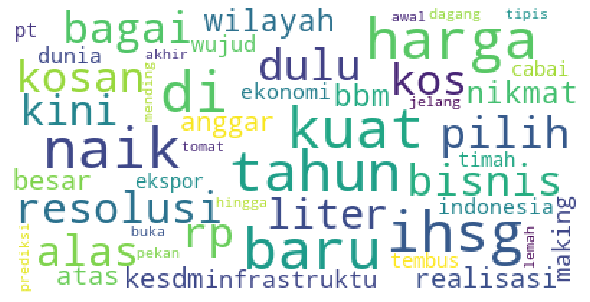

In [28]:
fig = plt.figure(figsize=(8,8),facecolor=None) 
plt.imshow(wordcloud.generate(str(df_full['title'])))
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig('Reports/figures/Worcloud Financial News.png',dpi=1000)

### 4.2 N-grams with network

In [29]:
# Determine n-grams
word_vectorizer = CountVectorizer(ngram_range=(1,3),analyzer='word')

### 4.2.1 Okezone

In [30]:
sparse_matrix = word_vectorizer.fit_transform(df_full[df_full['news'] == 'Okezone']['title'])
frequencies = sum(sparse_matrix).toarray()[0]
# Dataframe of N-grams
ngrams_okezone = pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])
ngrams_okezone.reset_index(level=0,inplace=True)

In [31]:
# N-Grams
ngrams = []
for i in range(ngrams_okezone.shape[0]):
    ngrams.append(len(str.split(ngrams_okezone.iloc[i]['index'])))
ngrams = pd.Series(ngrams,name='NGrams')

In [32]:
# Merge dataframe
ngrams_okezone = pd.concat([ngrams_okezone,ngrams],axis=1)
ngrams_okezone = ngrams_okezone.sort_values(by='frequency',ascending=False)

In [33]:
ngrams_okezone[ngrams_okezone.NGrams == 1].head()

,index,frequency,NGrams
45089,rp,2768,1
17433,harga,1323,1
55099,triliun,1100,1
19218,ihsg,968,1
13241,ekonomi,830,1


In [34]:
ngrams_okezone[ngrams_okezone.NGrams == 2].head()

,index,frequency,NGrams
45405,rp triliun,1085,2
45227,rp miliar,506,2
45643,rp usd,405,2
17593,harga emas,401,2
12395,dolar as,287,2


### 4.2.2 Kompas

In [35]:
sparse_matrix = word_vectorizer.fit_transform(df_full[df_full['news'] == 'Kompas']['title'])
frequencies = sum(sparse_matrix).toarray()[0]
# Dataframe of N-grams
ngrams_kompas = pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])
ngrams_kompas.reset_index(level=0,inplace=True)

In [36]:
# N-Grams
ngrams = []
for i in range(ngrams_kompas.shape[0]):
    ngrams.append(len(str.split(ngrams_kompas.iloc[i]['index'])))
ngrams = pd.Series(ngrams,name='NGrams')

In [37]:
# Merge dataframe
ngrams_kompas = pd.concat([ngrams_kompas,ngrams],axis=1)
ngrams_kompas = ngrams_kompas.sort_values(by='frequency',ascending=False)

In [38]:
ngrams_kompas[ngrams_kompas.NGrams == 1].head()

,index,frequency,NGrams
29716,rp,1152,1
11898,harga,591,1
8972,ekonomi,543,1
36440,triliun,542,1
14434,investasi,423,1


In [39]:
ngrams_kompas[ngrams_kompas.NGrams == 2].head()

,index,frequency,NGrams
29962,rp triliun,537,2
29835,rp miliar,243,2
12219,harga tiket,167,2
11994,harga emas,142,2
36872,tumbuh ekonomi,133,2


### 4.2.3 Detik

In [40]:
sparse_matrix = word_vectorizer.fit_transform(df_full[df_full['news'] == 'Detik']['title'])
frequencies = sum(sparse_matrix).toarray()[0]
# Dataframe of N-grams
ngrams_detik = pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])
ngrams_detik.reset_index(level=0,inplace=True)

In [41]:
# N-Grams
ngrams = []
for i in range(ngrams_detik.shape[0]):
    ngrams.append(len(str.split(ngrams_detik.iloc[i]['index'])))
ngrams = pd.Series(ngrams,name='NGrams')

In [42]:
# Merge dataframe
ngrams_detik = pd.concat([ngrams_detik,ngrams],axis=1)
ngrams_detik = ngrams_detik.sort_values(by='frequency',ascending=False)

In [43]:
ngrams_detik[ngrams_detik.NGrams == 1].head()

,index,frequency,NGrams
50970,rp,2856,1
20249,harga,1155,1
49547,ri,1024,1
22253,ihsg,864,1
15981,ekonomi,801,1


In [44]:
ngrams_detik[ngrams_detik.NGrams == 2].head()

,index,frequency,NGrams
51404,rp juta,335,2
14929,dolar as,326,2
51997,rp triliun,280,2
16353,ekonomi ri,250,2
56599,sri mulyani,223,2


### 4.3 3-grams with network

In [45]:
# Preparing the data
n3grams_okezone = ngrams_okezone[ngrams_okezone.NGrams == 3]
n3grams_kompas = ngrams_kompas[ngrams_kompas.NGrams == 3]
n3grams_detik = ngrams_detik[ngrams_detik.NGrams == 3]

In [46]:
# Add categories
cat_okezone = pd.Series(['Okezone']*n3grams_okezone.shape[0],name='cat')
cat_kompas = pd.Series(['Kompas']*n3grams_kompas.shape[0],name='cat')
cat_detik = pd.Series(['Detik']*n3grams_detik.shape[0],name='cat')
# Concate with each data
n3grams_okezone = pd.concat([n3grams_okezone,cat_okezone],axis=1)
n3grams_kompas = pd.concat([n3grams_kompas,cat_kompas],axis=1)
n3grams_detik = pd.concat([n3grams_detik,cat_detik],axis=1)
# Merge into one dataframe
trigram_df = pd.concat([n3grams_okezone.sort_values(by='frequency',ascending=False).head(20),
                        n3grams_kompas.sort_values(by='frequency',ascending=False).head(20),
                        n3grams_detik.sort_values(by='frequency',ascending=False).head(20)])

In [47]:
graph_net = nx.from_pandas_edgelist(trigram_df,source='cat',target='index')
print(nx.info(graph_net))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 57
Average degree:   2.2800


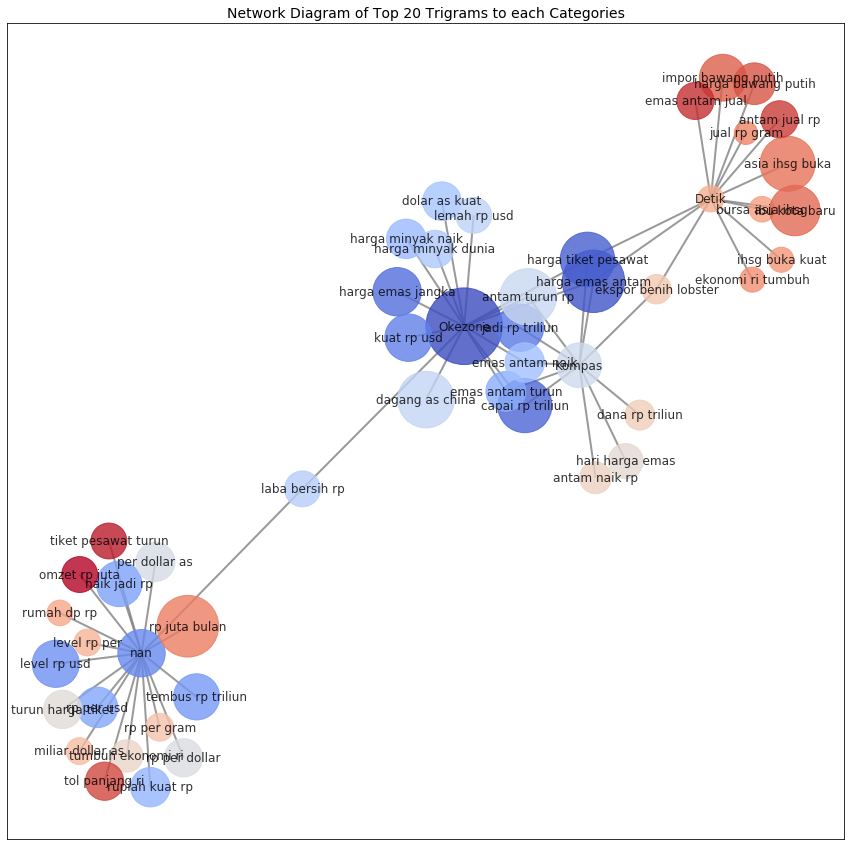

In [48]:
plt.figure(figsize=(15,15))
cmap = plt.cm.coolwarm
colors = [n for n in range(len(graph_net.nodes()))]
# k = 0.0319
k = 0.14
pos = nx.spring_layout(graph_net,k=k)
nx.draw_networkx(graph_net,pos,node_size=trigram_df['frequency'].values*30,cmap = cmap,
                        node_color=colors,edge_color='grey',font_size=12,width=2,alpha=0.8)
plt.title('Network Diagram of Top 20 Trigrams to each Categories',fontsize=14)
plt.savefig('Reports/figures/3-Grams Network.png',format='PNG',dpi=300)
plt.show()